In [1]:
from gplearn.genetic import SymbolicRegressor, SymbolicTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.utils.random import check_random_state
from mpl_toolkits.mplot3d import Axes3D
import graphviz
from IPython.display import Image
import pydotplus
import pandas as pd
import numpy as np
import datetime as dt
import scipy
import random
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import gplearn
from gplearn.functions import make_function
sns.set()
from pyeasyga import pyeasyga

In [2]:
# Statsのコード from 吉田さん
def format_float(panda, num):
    new = pd.DataFrame(index = panda.index, columns = panda.columns)
    name = '{:.' + str(num) + 'f}'
    for i in new.index:
        for j in new.columns: new.at[i,j] = name.format(panda.at[i,j])
    return new

def performance_stats(rets):
    outs = ['Ret%','Std%','DDBMax%','DDBMed%','TuWMax','TuWMed',
            'SR','Skew','Kurt','Corr',
            'hit%','AvgHit%','AvgLos%']
    outs_mat = pd.DataFrame(index=outs, columns=rets.columns)
    ret_pct = rets.pct_change().dropna()
    ret_pct_M = rets.resample('1M').last().pct_change().dropna()
    outs_mat.loc['Ret%',:] = (np.exp(np.log(ret_pct_M + 1.).mean()*12)-1)*100
    outs_mat.loc['Std%',:] = (ret_pct_M.std(ddof=0) * np.sqrt(12)
                              * 100.).replace(0, 0.01)
    DD_flow = rets / rets.cummax()
    outs_mat.loc['DDBMax%',:] = (1.-DD_flow.min())*100.
    outs_mat.loc['DDBMed%',:] = (1.-DD_flow.median())*100.
    DD_count = (DD_flow < (1. - 1e-10)).astype(int)
    DD_range = pd.DataFrame(0, index=rets.index, columns=rets.columns)
    iter_num = len(DD_range) - 1
    for i in range(iter_num):
        prev, now = rets.index[[i,i+1]]
        DD_range.loc[now,:] = (DD_range.loc[prev,:]+1) * DD_count.loc[prev,:]
    outs_mat.loc['TuWMax',:] = DD_range.max() / 21
    outs_mat.loc['TuWMed',:] = DD_range.median() / 21
    outs_mat.loc['SR',:] = outs_mat.loc['Ret%',:] / outs_mat.loc['Std%',:]
    outs_mat.loc['Skew',:] = ret_pct_M.skew()
    outs_mat.loc['Kurt',:] = ret_pct_M.kurt()
    outs_mat.loc['Corr',:] = ret_pct.corr().iloc[-1,:]
    outs_mat.loc['hit%',:] = ((ret_pct_M > 0).sum() / len(ret_pct_M)) * 100. ##len(ret_pct_M[ret_pct_M!=0])
    outs_mat.loc['AvgHit%',:] = ((ret_pct_M * (ret_pct_M > 0)).sum() /(ret_pct_M > 0).sum()) * 100. 
    outs_mat.loc['AvgLos%',:] = ((ret_pct_M * (ret_pct_M < 0)).sum() /(ret_pct_M < 0).sum()) * 100.
    out_put = format_float(outs_mat, 2)
    return out_put

In [3]:
def index(dataset):
    dataset_index = dataset.copy()
    dataset_index.iloc[0] = 100*(dataset.iloc[0]+1)
    for i in range(1,len(dataset_index)) :
        dataset_index.iloc[i]=(dataset_index.iloc[i]+1)*dataset_index.iloc[i-1]
    return dataset_index

In [4]:
Index_futures = pd.read_excel('Index Futures.xlsx',index_col=0,parse_dates=True)

In [29]:
Index_futures.head(20)

,SP1 Index,NK1 Index,IFB1 Index,SHY1 Index
Dates,,,,
2005-01-04,1191.0,11540,NaN,NaN
2005-01-05,1183.2,11430,NaN,NaN
2005-01-06,1188.2,11480,NaN,NaN
2005-01-07,1186.3,11470,NaN,NaN
2005-01-10,1191.7,11470,NaN,NaN
2005-01-11,1183.9,11550,NaN,NaN
2005-01-12,1187.5,11470,NaN,NaN
2005-01-13,1177.9,11370,NaN,NaN
2005-01-14,1183.8,11450,NaN,NaN


In [6]:
Index_futures_log_return = (np.log(Index_futures)-np.log(Index_futures.shift(1)))
Index_futures_log_return = Index_futures_log_return[(Index_futures_log_return.index >= dt.datetime(2006,1,1)) & (Index_futures_log_return.index <= dt.datetime(2017,12,31))]
Index_futures_log_return = Index_futures_log_return.dropna(how='any',axis=1)

In [32]:
Index_futures_return = (Index_futures-Index_futures.shift(1))/Index_futures*100

In [33]:
Index_futures_return.head(20)

,SP1 Index,NK1 Index,IFB1 Index,SHY1 Index
Dates,,,,
2005-01-04,NaN,NaN,NaN,NaN
2005-01-05,-0.659229,-0.962380,NaN,NaN
2005-01-06,0.420805,0.435540,NaN,NaN
2005-01-07,-0.160162,-0.087184,NaN,NaN
2005-01-10,0.453134,0.000000,NaN,NaN
2005-01-11,-0.658839,0.692641,NaN,NaN
2005-01-12,0.303158,-0.697472,NaN,NaN
2005-01-13,-0.815010,-0.879507,NaN,NaN
2005-01-14,0.498395,0.698690,NaN,NaN


In [68]:
Index_futures_return_SP1=Index_futures_return["SP1 Index"].replace(0.,np.nan).dropna()
Index_futures_return_SP1

Dates
2005-01-05   -0.659229
2005-01-06    0.420805
2005-01-07   -0.160162
2005-01-10    0.453134
2005-01-11   -0.658839
                ...   
2020-07-13   -0.959278
2020-07-14    1.111949
2020-07-15    1.112008
2020-07-16   -0.779465
2020-07-17    0.603628
Name: SP1 Index, Length: 3896, dtype: float64

In [7]:
Index_futures_log_return_SP1=Index_futures_log_return["SP1 Index"]

In [8]:
Index_futures_log_return_SP1

Dates
2006-01-02    0.000000
2006-01-03    0.015735
2006-01-04    0.004540
2006-01-05    0.000625
2006-01-06    0.008161
                ...   
2017-12-25    0.000000
2017-12-26    0.000372
2017-12-27   -0.000633
2017-12-28    0.000112
2017-12-29   -0.003618
Name: SP1 Index, Length: 3130, dtype: float64

In [69]:
SP_In_Sample_new = Index_futures_return_SP1[(Index_futures_return_SP1.index >= dt.datetime(2006,1,1)) & (Index_futures_return_SP1.index <= dt.datetime(2011,12,31))]
SP_Out_Of_Sample_new = Index_futures_return_SP1[Index_futures_return_SP1.index > dt.datetime(2011,12,31)]

In [70]:
SP_dataset_x_return = [SP_In_Sample_new[0:3]]
for i in range(1,len(SP_In_Sample_new)-3):
    SP_dataset_x_return = np.r_[SP_dataset_x_return,[SP_In_Sample_new[i:i+3]]]

In [71]:
SP_dataset_x_OoS_return = [SP_Out_Of_Sample_new[0:3]]
for i in range(1,len(SP_Out_Of_Sample_new)-3):
    SP_dataset_x_OoS_return = np.r_[SP_dataset_x_OoS_return,[SP_Out_Of_Sample_new[i:i+3]]]

In [72]:
SP_dataset_y_return = SP_In_Sample_new[3:].values

In [9]:
SP1_Index = index(Index_futures_log_return['SP1 Index'])
NK1_Index = index(Index_futures_log_return['NK1 Index'])

In [10]:
Index_futures_log_return_SP1

Dates
2006-01-02    0.000000
2006-01-03    0.015735
2006-01-04    0.004540
2006-01-05    0.000625
2006-01-06    0.008161
                ...   
2017-12-25    0.000000
2017-12-26    0.000372
2017-12-27   -0.000633
2017-12-28    0.000112
2017-12-29   -0.003618
Name: SP1 Index, Length: 3130, dtype: float64

In [11]:
SP_In_Sample = Index_futures_log_return_SP1[(Index_futures_log_return_SP1.index >= dt.datetime(2006,1,1)) & (Index_futures_log_return_SP1.index <= dt.datetime(2011,12,31))]
SP_Out_Of_Sample = Index_futures_log_return_SP1[Index_futures_log_return_SP1.index > dt.datetime(2011,12,31)]
SP_Index_In_Sample = SP1_Index[(SP1_Index.index >= dt.datetime(2006,1,1)) & (SP1_Index.index <= dt.datetime(2011,12,31))]

In [13]:
SP_dataset_x = [SP_In_Sample[0:3]]
for i in range(1,len(SP_In_Sample)-3):
    SP_dataset_x = np.r_[SP_dataset_x,[SP_In_Sample[i:i+3]]]
SP_dataset_x_new = SP_dataset_x*10000 
    

In [14]:
SP_dataset_x_OoS = [SP_Out_Of_Sample[0:3]]
for i in range(1,len(SP_Out_Of_Sample)-3):
    SP_dataset_x_OoS = np.r_[SP_dataset_x_OoS,[SP_Out_Of_Sample[i:i+3]]]
SP_dataset_x_OoS_new = SP_dataset_x_OoS*10000

In [42]:
print(SP_dataset_x_OoS_return)
len(SP_dataset_x_OoS_return)

[[ 0.          1.53289836  0.07069914]
 [ 1.53289836  0.07069914  0.00785484]
 [ 0.07069914  0.00785484  0.08632868]
 ...
 [-0.95927832  1.11194874  1.11200845]
 [ 1.11194874  1.11200845 -0.7794647 ]
 [ 1.11200845 -0.7794647   0.60362799]]


2228

In [16]:
SP_dataset_x

array([[ 0.00000000e+00,  1.57346595e-02,  4.53976985e-03],
       [ 1.57346595e-02,  4.53976985e-03,  6.24560876e-04],
       [ 4.53976985e-03,  6.24560876e-04,  8.16140708e-03],
       ...,
       [ 8.92649587e-03,  0.00000000e+00, -7.93493355e-05],
       [ 0.00000000e+00, -7.93493355e-05, -1.25365957e-02],
       [-7.93493355e-05, -1.25365957e-02,  1.03122541e-02]])

In [17]:
SP_dataset_y = SP_In_Sample[3:].values
SP_dataset_y_OoS = SP_Out_Of_Sample[3:].values
SP_dataset_y_OoS_new = SP_dataset_y_OoS*10000
SP_dataset_y_new = SP_dataset_y*10000
SP_Index_dataset_y = SP_Index_In_Sample.values[3:]
print(SP_dataset_y)
#print(SP_Index_dataset_y)

[ 0.00062456  0.00816141  0.00239688 ... -0.0125366   0.01031225
 -0.00382471]


In [18]:
len(SP_dataset_y)
len(SP_Index_dataset_y)

1562

In [19]:
print(SP_dataset_y_new/10)

[  0.62456088   8.16140708   2.39687748 ... -12.5365957   10.31225414
  -3.82470586]


In [56]:
# log*indicator function
def log_indi(x):
    a = x*np.array(x>0)
    if 0 in a:
        return 0*x
    else:
        return np.log(a)


In [57]:
a = np.array([2,4,3,0,2])
log_indi(a)

array([0, 0, 0, 0, 0])

In [58]:
log_indi = make_function(function=log_indi, name='log_indi', arity=1)

In [23]:
def pow_3(x1):
    f = x1**3
    return f
pow_3 = make_function(function=pow_3,name='pow3',arity=1)

In [46]:
SP_dataset_x_return
len(SP_dataset_x_return)

1562

In [47]:
SP_dataset_y_return
len(SP_dataset_y_return)

1562

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   235.72      3.01738e+28        5          1.47219          2.02341     11.35m
   1     7.62          170.676        7          1.43767          2.23827      4.13m
   2     3.17          1.77126        3            1.432          2.27058      2.03m
   3     2.64          1.66624        3          1.42337          2.32965      1.71m
   4     2.16          1.62364        3           1.4257          2.36922      1.42m
   5     1.61           1.5865        1           1.4272          2.30688      1.62m
   6     1.22          1.55677        1          1.40321          2.42606      1.04m
   7     1.06           1.5436        1          1.41501          2.37082     30.93s
   8     1.01          1.54069        1          1.43655           2.2491  

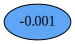

In [67]:
# Return as input
init_depth = (1,10)
function_set = ['add', 'sub','mul','div']
est_gp_index_0 = SymbolicRegressor(population_size=10000,function_set=function_set,init_depth = init_depth,
                           generations=10, metric='rmse',stopping_criteria=0.01,
                           p_crossover=0.8, p_subtree_mutation=0,
                           p_hoist_mutation=0, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0,n_jobs=-1)
est_gp_index_0.fit(SP_dataset_x_return, SP_dataset_y_return)
dot_data = est_gp_index_0._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

In [49]:
print(est_gp_index_0._program)
#est_gp_index_0.predict(SP_dataset_x_OoS_new)

div(mul(-0.619, X2), add(X1, add(sub(-0.102, 0.895), sub(add(X0, sub(X2, div(sub(X1, X1), add(sub(X2, X1), mul(X2, 0.983))))), sub(X2, X1)))))


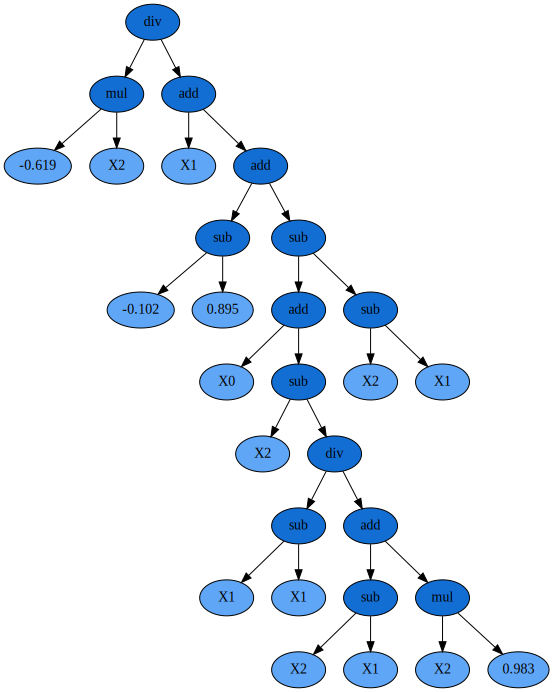

In [77]:
# Return as input
init_depth = (1,10)
function_set = ['add', 'sub','mul','div']
est_gp_index_1 = SymbolicRegressor(population_size=1000,function_set=function_set,init_depth = init_depth,
                           generations=50, metric='rmse',stopping_criteria=0.01,
                           p_crossover=0.8, p_subtree_mutation=0,
                           p_hoist_mutation=0, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0,n_jobs=-1)
est_gp_index_1.fit(SP_dataset_x_return*100, SP_dataset_y_return*100)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   234.03      3.06184e+69        7          147.088          227.539      6.80m
   1    34.45      9.72931e+09        7          147.973           222.37      3.07m
   2    29.18       4.3915e+16       67          148.463          219.333      2.40m
   3    30.62      1.05643e+17        9          146.681          230.013      2.07m
   4    26.98      1.39332e+11       37          145.343          237.378      2.28m
   5    28.66      1.97053e+10        5          148.088          221.588      3.73m
   6    28.78      4.35881e+10        3          147.159          227.168      3.36m
   7    26.64      2.13521e+19       15          146.676          229.845      2.20m
   8    22.18      7.89244e+09       41          148.904          216.581  

SymbolicRegressor(function_set=['add', 'sub', 'mul', 'div'], generations=50,
                  init_depth=(1, 10), max_samples=0.9, metric='rmse', n_jobs=-1,
                  p_crossover=0.8, p_hoist_mutation=0, p_point_mutation=0.1,
                  p_subtree_mutation=0, parsimony_coefficient=0.01,
                  random_state=0, stopping_criteria=0.01, verbose=1)

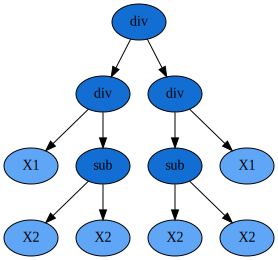

In [78]:
dot_data = est_gp_index_1._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   219.46      1.98096e+22        3           1.4567          2.13216      1.05m
   1     6.81          13.5847        3          1.44919          2.17959     21.56s
   2     2.97          1.68237        1          1.43528          2.25173     11.85s
   3     2.33          1.64074        3          1.45569          2.13154     10.02s
   4     1.87          1.60215        1          1.46063          2.10111      7.37s
   5     1.31          1.57416        1          1.42647          2.30158      7.88s
   6     1.04          1.54981        1          1.45089          2.16064      4.31s
   7     1.01          1.54227        1          1.45992           2.1055      2.86s
   8     1.00          1.54242        1           1.4371          2.24137  

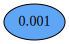

In [62]:
# Return as input
function_set = ['add', 'sub','div','mul']
est_gp_index_1 = SymbolicRegressor(population_size=1000,function_set=function_set,init_depth = init_depth,
                           generations=10, metric='rmse',stopping_criteria=0.01,
                           p_crossover=0.8, p_subtree_mutation=0,
                           p_hoist_mutation=0, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=1,n_jobs=-1)
est_gp_index_1.fit(SP_dataset_x_return, SP_dataset_y_return)
dot_data = est_gp_index_1._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   219.46      1.98096e+22        3           1.4567          2.13216      4.66m
   1     6.81          13.5847        3          1.44919          2.17959      2.44m
   2     2.97          1.68237        1          1.43528          2.25173      1.42m
   3     2.33          1.64074        3          1.45569          2.13154      1.16m
   4     1.87          1.60215        1          1.46063          2.10111      1.09m
   5     1.31          1.57416        1          1.42647          2.30158      1.33m
   6     1.04          1.54981        1          1.45089          2.16064      1.51m
   7     1.01          1.54227        1          1.45992           2.1055      1.16m
   8     1.00          1.54242        1           1.4371          2.24137  

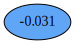

In [63]:
# Return as input
function_set = ['add', 'sub','div','mul']
est_gp_index_2 = SymbolicRegressor(population_size=1000,function_set=function_set,init_depth = init_depth,
                           generations=50, metric='rmse',stopping_criteria=0.01,
                           p_crossover=0.8, p_subtree_mutation=0,
                           p_hoist_mutation=0, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=1,n_jobs=-1)
est_gp_index_2.fit(SP_dataset_x_return, SP_dataset_y_return)
dot_data = est_gp_index_2._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   103.17      3.12705e+06        8          1.41992          2.33748      1.96m
   1     4.64          1.79955        6          1.43579          2.24905      2.46m
   2     2.48          1.62911        2          1.44312          2.20667      2.29m
   3     2.16          1.60421        3          1.45569          2.13154      1.45m
   4     2.07          1.58967        2          1.46062           2.1011      3.02m
   5     2.07          1.58248        2          1.42647          2.30153      3.90m
   6     2.08          1.57972        2          1.45088          2.16066      2.73m
   7     2.07          1.58423        2          1.45992          2.10549      3.27m
   8     2.09          1.57887        2          1.43718          2.24113  

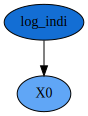

In [64]:
# Return as input
function_set = ['add', 'sub','div','mul',log_indi]
est_gp_index_3 = SymbolicRegressor(population_size=1000,function_set=function_set,init_depth = init_depth,
                           generations=50, metric='rmse',stopping_criteria=0.01,
                           p_crossover=0.8, p_subtree_mutation=0,
                           p_hoist_mutation=0, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=1,n_jobs=-1)
est_gp_index_3.fit(SP_dataset_x_return, SP_dataset_y_return)
dot_data = est_gp_index_3._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   103.17      4.76304e+23        8          141.992          233.748      2.37m
   1    31.88           267264        6          143.579          224.905      6.00m
   2    22.64            87736        2          143.532          225.174      4.88m
   3    12.95          2756.86        3          145.569          213.154      2.42m
   4    10.72          1185.23        2          146.062           210.11      2.40m
   5    11.07          972.756        7          142.813           229.63      3.56m
   6     9.85            58752        7          145.088          216.066      3.17m
   7     7.76          27491.1        2          145.992          210.549      3.09m
   8     7.86           1124.9        3          143.718          224.113  

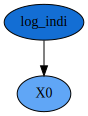

In [65]:
# Return*100 as input
function_set = ['add', 'sub','div','mul',log_indi]
est_gp_index_3 = SymbolicRegressor(population_size=1000,function_set=function_set,init_depth = init_depth,
                           generations=50, metric='rmse',stopping_criteria=0.01,
                           p_crossover=0.8, p_subtree_mutation=0,
                           p_hoist_mutation=0, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=1,n_jobs=-1)
est_gp_index_3.fit(SP_dataset_x_return*100, SP_dataset_y_return*100)
dot_data = est_gp_index_3._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   104.67      3.10155e+06       48          1.38081          2.53852      5.57m
   1     4.38          2.52545        4          1.41973           2.3385      3.36m
   2     2.41          1.62746        2          1.39694          2.45828      2.17m
   3     2.18          1.58041        2           1.4083          2.39959      1.99m
   4     2.07          1.57713        2          1.42115           2.3308      1.45m
   5     2.02          1.57403        2          1.40045          2.44033      1.34m
   6     1.98          1.57331        2          1.41351          2.37202      1.40m
   7     1.90          1.56962        2          1.39921          2.44672      1.18m
   8     1.81          1.56846        1          1.41544          2.36271  

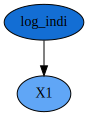

In [66]:
# Return as input
function_set = ['add', 'sub','div','mul',log_indi]
est_gp_index_3 = SymbolicRegressor(population_size=10000,function_set=function_set,init_depth = init_depth,
                           generations=10, metric='rmse',stopping_criteria=0.01,
                           p_crossover=0.8, p_subtree_mutation=0,
                           p_hoist_mutation=0, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=1,n_jobs=-1)
est_gp_index_3.fit(SP_dataset_x_return, SP_dataset_y_return)
dot_data = est_gp_index_3._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

In [48]:
print(est_gp_index_1._program)
prediction = est_gp_index_1.predict(SP_dataset_x_OoS_new)
print(prediction)
print(SP_dataset_y_OoS_new)
est_gp_index_1.score(prediction.reshape(-1, 1),SP_dataset_y_OoS_new.reshape(-1, 1))

div(-0.295, add(X0, sub(X0, X0)))
1562
[ 1.         -0.00191223 -0.04176723 ...  0.04668894  1.
 -0.07936086]
1562
[  0.7855151    8.63659615  10.98125454 ...  -6.32852511   1.11708961
 -36.18259352]
1562


ValueError: Number of features of the model must match the input. Model n_features is 3 and input n_features is 1.

In [49]:
prediction.reshape(-1, 1)

array([[ 1.        ],
       [-0.00191223],
       [-0.04176723],
       ...,
       [ 0.04668894],
       [ 1.        ],
       [-0.07936086]])

In [50]:
SP_dataset_y_OoS_new.reshape(-1, 1)

array([[  0.7855151 ],
       [  8.63659615],
       [ 10.98125454],
       ...,
       [ -6.32852511],
       [  1.11708961],
       [-36.18259352]])

In [56]:
sum(prediction*SP_dataset_y_OoS_new > 0)/len(prediction)

0.47695262483994877

In [58]:
# Log Return *10000 as input
function_set = ['add', 'sub','div','mul']
est_gp_index_2 = SymbolicRegressor(population_size=1000,function_set=function_set,init_depth = init_depth,
                           generations=100, metric='rmse',stopping_criteria=0.01,
                           p_crossover=0.8, p_subtree_mutation=0,
                           p_hoist_mutation=0, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=2,n_jobs=-1)
est_gp_index_2.fit(SP_dataset_x_new, SP_dataset_y_new)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   241.93      2.49982e+76     2047          147.109          202.125     11.46m
   1    36.28      5.44003e+22       13          142.531          229.617      4.54m
   2    18.63      7.84824e+19        3          146.654          205.096      2.92m
   3    16.67      1.15066e+16       17          143.877          221.968      2.83m
   4    17.16      3.51906e+18       15          144.397          218.918      2.63m
   5    14.83      2.91252e+15       29          143.777          223.117      2.91m
   6    14.74       1.4833e+18        3          144.539          218.088      2.71m
   7    15.31      1.51479e+10       59          143.997          221.264      2.84m
   8    16.35      1.09385e+14       25          141.933          232.899  

SymbolicRegressor(function_set=['add', 'sub', 'div', 'mul'], generations=100,
                  init_depth=(1, 10), max_samples=0.9, metric='rmse', n_jobs=-1,
                  p_crossover=0.8, p_hoist_mutation=0, p_point_mutation=0.1,
                  p_subtree_mutation=0, parsimony_coefficient=0.01,
                  random_state=2, stopping_criteria=0.01, verbose=1)

In [59]:
print(est_gp_index_2._program)
prediction = est_gp_index_2.predict(SP_dataset_x_OoS_new)
print(prediction)
print(SP_dataset_y_OoS_new)
sum(prediction*SP_dataset_y_OoS_new > 0)/len(prediction)

mul(mul(mul(X1, sub(X0, X0)), mul(div(0.589, X1), mul(mul(sub(X1, X1), X1), X1))), div(X1, X1))
[0. 0. 0. ... 0. 0. 0.]
[  0.7855151    8.63659615  10.98125454 ...  -6.32852511   1.11708961
 -36.18259352]


0.0

In [25]:
# Log Return *10000 as input

est_gp_index_3 = SymbolicRegressor(population_size=10000,function_set=function_set,init_depth = init_depth,
                           generations=10, metric='rmse',stopping_criteria=0.01,
                           p_crossover=0.8, p_subtree_mutation=0,
                           p_hoist_mutation=0, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=3,n_jobs=-1)
est_gp_index_3.fit(SP_dataset_x_new, SP_dataset_y_new)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    84.64      2.34235e+48       20          142.134          231.801      2.62m
   1    32.86      2.48818e+13       38          139.929          243.511      2.67m
   2    22.48      3.71497e+15       86          142.744          228.424      2.28m
   3    20.19      8.52491e+09       28           141.67          234.328      1.78m
   4    18.59      2.72912e+14       53          141.146          237.141      1.56m
   5    16.93      1.00611e+13        7          141.343          236.222      1.69m
   6    16.08      1.27725e+13       14           142.95          227.266      1.89m
   7    15.37      8.62141e+09       34          141.814          233.547      1.66m
   8    14.73      1.16212e+10       26           140.58          240.131  

SymbolicRegressor(function_set=['add', 'sub', 'mul',
                  generations=10, init_depth=(1, 10), max_samples=0.9,
                  metric='rmse', n_jobs=-1, p_crossover=0.8, p_hoist_mutation=0,
                  p_point_mutation=0.1, p_subtree_mutation=0,
                  parsimony_coefficient=0.01, population_size=10000,
                  random_state=3, stopping_criteria=0.01, verbose=1)

In [26]:
# Log Return *10000 as input
est_gp_index_4 = SymbolicRegressor(population_size=10000,function_set=function_set,init_depth = init_depth,
                           generations=10, metric='rmse',stopping_criteria=0.01,
                           p_crossover=0.8, p_subtree_mutation=0,
                           p_hoist_mutation=0, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=4,n_jobs=-1)
est_gp_index_4.fit(SP_dataset_x_new, SP_dataset_y_new)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    82.92      2.99708e+38       79          139.393           246.25      3.14m
   1    33.80      2.51727e+15       12          139.625          245.069      2.87m
   2    23.44      2.69124e+14       48          140.448          240.826      2.27m
   3    21.97      6.97653e+13        6          140.713          239.436      3.10m
   4    19.72      2.99235e+12       10          140.772          239.122      1.66m
   5    18.53      3.34865e+09       86           141.44           235.57      1.70m
   6    17.01      1.61115e+09       10          141.518          235.149      1.77m
   7    15.62      1.98768e+09        7          142.649          228.955      1.69m
   8    15.92      2.34951e+07       12          139.784          244.257  

SymbolicRegressor(function_set=['add', 'sub', 'mul',
                  generations=10, init_depth=(1, 10), max_samples=0.9,
                  metric='rmse', n_jobs=-1, p_crossover=0.8, p_hoist_mutation=0,
                  p_point_mutation=0.1, p_subtree_mutation=0,
                  parsimony_coefficient=0.01, population_size=10000,
                  random_state=4, stopping_criteria=0.01, verbose=1)

In [45]:
# Log Return *10000 as input
est_gp_index_5 = SymbolicRegressor(population_size=10000,function_set=function_set,init_depth = init_depth,
                           generations=1, metric='rmse',stopping_criteria=0.01,
                           p_crossover=0.8, p_subtree_mutation=0,
                           p_hoist_mutation=0, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=2,n_jobs=-1)
est_gp_index_5.fit(SP_dataset_x_new, SP_dataset_y_new)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    85.99       8.9772e+43        9          136.114          262.151      0.00s


SymbolicRegressor(function_set=['add', 'sub', 'mul',
                  generations=1, init_depth=(1, 10), max_samples=0.9,
                  metric='rmse', n_jobs=-1, p_crossover=0.8, p_hoist_mutation=0,
                  p_point_mutation=0.1, p_subtree_mutation=0,
                  parsimony_coefficient=0.01, population_size=10000,
                  random_state=2, stopping_criteria=0.01, verbose=1)

In [49]:
# Log Return *10000 as input
func = ['add', 'sub', 'mul']
est_gp_index_6 = SymbolicRegressor(population_size=10000,function_set=func,init_depth = init_depth,
                           generations=10, metric='rmse',stopping_criteria=0.01,
                           p_crossover=0.8, p_subtree_mutation=0,
                           p_hoist_mutation=0, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=6,n_jobs=-1)
est_gp_index_6.fit(SP_dataset_x_new, SP_dataset_y_new)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   226.19              nan     2047              nan              nan      5.77m
   1   165.57              nan     2043              nan              nan      4.16m
   2  1540.88              nan     2043              nan              nan     15.76m


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/seungjuseo/.pyenv/versions/3.7.1/envs/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-49-1126ec59261c>", line 9, in <module>
    est_gp_index_6.fit(SP_dataset_x_new, SP_dataset_y_new)
  File "/Users/seungjuseo/.pyenv/versions/3.7.1/envs/myenv/lib/python3.7/site-packages/gplearn/genetic.py", line 471, in fit
    for i in range(n_jobs))
  File "/Users/seungjuseo/.pyenv/versions/3.7.1/envs/myenv/lib/python3.7/site-packages/joblib/parallel.py", line 1017, in __call__
    self.retrieve()
  File "/Users/seungjuseo/.pyenv/versions/3.7.1/envs/myenv/lib/python3.7/site-packages/joblib/parallel.py", line 909, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/Users/seungjuseo/.pyenv/versions/3.7.1/envs/myenv/lib/python3.7/site-packages/joblib/_parallel_backends.py", line 562, in wrap_future_result
    re

KeyboardInterrupt: 

In [46]:
print(est_gp_index_0._program)
print(est_gp_index_1._program)
print(est_gp_index_2._program)
print(est_gp_index_3._program)
print(est_gp_index_4._program)
print(est_gp_index_5._program)

log_indi(add(log_indi(X1), log_indi(mul(log_indi(add(X2, X2)), sub(mul(mul(log_indi(X1), log_indi(X0)), log_indi(X1)), log_indi(X2))))))
mul(log_indi(log_indi(add(log_indi(0.628), log_indi(X0)))), log_indi(sub(X2, X0)))
add(log_indi(0.436), mul(mul(0.229, log_indi(log_indi(log_indi(log_indi(X2))))), log_indi(add(X2, X2))))
log_indi(log_indi(sub(mul(log_indi(log_indi(X0)), log_indi(X2)), X0)))
log_indi(mul(sub(add(X2, X0), log_indi(X0)), mul(add(X2, X1), log_indi(mul(mul(add(sub(add(X0, 0.485), sub(X1, X0)), add(-0.654, X1)), mul(add(-0.016, mul(log_indi(log_indi(log_indi(X0))), X0)), log_indi(X2))), log_indi(sub(mul(X0, -0.834), X2)))))))
log_indi(add(log_indi(X0), sub(add(X1, 0.877), -0.345)))


In [33]:
est_gp_index_0.predict(SP_dataset_x_OoS_new)

array([ 0.,  0.,  0., ..., -0., -0.,  0.])

In [34]:
est_gp_index_1.predict(SP_dataset_x_OoS_new)

array([-0.,  0., -0., ...,  0., -0.,  0.])

In [35]:
est_gp_index_2.predict(SP_dataset_x_OoS_new)

array([-0.82929312, -0.82929312, -0.82929312, ..., -0.82929312,
       -0.82929312, -0.82929312])

In [37]:
est_gp_index_3.predict(SP_dataset_x_OoS_new)

array([ 0., -0., -0., ..., -0.,  0., -0.])

In [38]:
est_gp_index_4.predict(SP_dataset_x_OoS_new)

array([-0.,  0.,  0., ..., -0.,  0., -0.])

In [47]:
est_gp_index_5.predict(SP_dataset_x_OoS_new)

array([ 0.,  0.,  0., ...,  0., -0., -0.])

In [39]:
len(est_gp_index_4.predict(SP_dataset_x_OoS_new))

1563

In [40]:
len(SP_dataset_x_OoS_new)

1563

In [41]:
SP_dataset_x_OoS_new

array([[   0.        ,  157.34659472,   45.39769851],
       [ 157.34659472,   45.39769851,    6.24560876],
       [  45.39769851,    6.24560876,   81.61407083],
       ...,
       [   0.        ,   -0.79349335, -125.365957  ],
       [  -0.79349335, -125.365957  ,  103.12254141],
       [   3.72217677,   -6.32852511,    1.11708961]])

In [48]:
est_gp_index._program.parents

{'method': 'Crossover',
 'parent_idx': 3084,
 'parent_nodes': range(11, 17),
 'donor_idx': 8216,
 'donor_nodes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}

In [45]:
get_best_indi(est_gp_index)[2][7].parents

0
log_indi(add(log_indi(X1), log_indi(mul(log_indi(add(X2, X2)), sub(add(mul(-0.145, X1), log_indi(X2)), log_indi(X2))))))
1
log_indi(add(log_indi(X1), log_indi(mul(log_indi(add(X2, X2)), sub(add(mul(-0.145, X1), log_indi(X2)), mul(log_indi(X1), X0))))))
2
log_indi(add(log_indi(X1), log_indi(mul(log_indi(mul(mul(X0, X0), mul(log_indi(log_indi(mul(add(X0, 0.217), log_indi(log_indi(log_indi(mul(X1, 0.864))))))), X2))), sub(add(mul(-0.145, X1), log_indi(X2)), mul(log_indi(X1), X0))))))
3
log_indi(add(log_indi(X1), log_indi(mul(log_indi(mul(mul(X0, X0), mul(log_indi(log_indi(mul(add(X0, 0.217), log_indi(log_indi(log_indi(sub(X1, 0.864))))))), X2))), add(add(mul(-0.145, X1), log_indi(X2)), mul(log_indi(X1), X0))))))
4
log_indi(add(log_indi(X1), log_indi(mul(log_indi(mul(mul(X0, X0), mul(X1, X2))), add(add(mul(-0.145, X1), log_indi(X2)), mul(log_indi(X1), X0))))))
5
log_indi(add(log_indi(X1), log_indi(mul(log_indi(mul(mul(X0, X0), mul(X1, X2))), add(add(mul(-0.145, X1), log_indi(X2)), mul(lo

{'method': 'Crossover',
 'parent_idx': 6065,
 'parent_nodes': range(0, 13),
 'donor_idx': 5232,
 'donor_nodes': [0, 1, 6, 7]}

In [66]:
get_best_indi(est_gp_index)

In [57]:
# Get every best individual for each generation 
def get_best_indi(est_gp):
    num_gen = len(est_gp._programs)
    parent = est_gp._program.parents # best programである_programのparentsの情報
    parent_index = parent['parent_idx'] # parentのindex
    best_indi_list = [est_gp._program]
    parent_info = []
    for i in range(num_gen-2):
        #print(i)
        previous_best_indi = est_gp._programs[-(i+2)][parent_index]
        best_indi_list.append(previous_best_indi)
        #print(best_indi_list)
        parent_info.append(parent)
        parent = previous_best_indi.parents
        #print(parent)
        parent_index = parent['parent_idx'] # parentのindexの更新
        #print(previous_best_indi)
    return best_indi_list

In [23]:
# Log Return *10000 as input, 10 generation
init_depth = (1,10)
function_set = ['add', 'sub', 'mul',log_indi]
est_gp_index = SymbolicRegressor(population_size=10000,function_set=function_set,init_depth = init_depth,
                           generations=10, metric='rmse',stopping_criteria=0.01,
                           p_crossover=0.8, p_subtree_mutation=0,
                           p_hoist_mutation=0, p_point_mutation=0.1,p_point_replace=0.05,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient='auto', random_state=0,n_jobs=-1)
est_gp_index.fit(SP_dataset_x_new, SP_dataset_y_new)
print(est_gp_index._program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    86.00      2.88703e+44        6           142.19          231.495      3.68m
   1     2.40          26049.4        2          142.818          228.008      2.77m
   2     1.17          187.477        1          143.193          225.893      2.50m
   3     2.01          157.395        2           141.66          234.386      2.25m
   4     2.93          154.959        5          141.093          237.426      2.15m
   5     4.19          153.967        3          141.564          234.902      3.24m
   6     5.15          153.895        3          139.885          243.738      3.41m
   7     6.03          153.845        2          140.839          238.772      3.10m
   8     7.11          153.703        7          139.651          244.937  

In [23]:
est_gp_index._program.parents

{'method': 'Crossover',
 'parent_idx': 3084,
 'parent_nodes': range(3, 6),
 'donor_idx': 8216,
 'donor_nodes': [0, 1, 2]}

In [64]:
get_best_indi(est_gp_index)

log_indi(log_indi(log_indi(log_indi(log_indi(X0)))))


(3084,
 [<gplearn._program._Program at 0x13fe622b0>])

In [51]:
len(est_gp_index._programs)

10

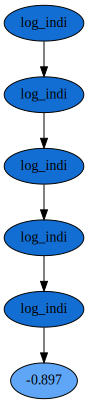

In [24]:
dot_data = est_gp_index._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

In [25]:
print(est_gp_index)

log_indi(log_indi(log_indi(log_indi(log_indi(-0.897)))))


In [53]:
# est_gp_index._programsに全てのParentsの記録が残る
#print(len(est_gp_index._programs))
print(est_gp_index._programs[-1][0]._program)

AttributeError: '_Program' object has no attribute '_program'

In [102]:
print(est_gp_index._program.parents)

AttributeError: 'SymbolicRegressor' object has no attribute '_program'

In [67]:
est_gp_index._program.parents

{'method': 'Crossover',
 'parent_idx': 3084,
 'parent_nodes': range(3, 6),
 'donor_idx': 8216,
 'donor_nodes': [0, 1, 2]}

In [91]:
print(est_gp_index._programs[-1][-10].parents)

{'method': 'Point Mutation', 'parent_idx': 8810, 'parent_nodes': [3]}


{'method': 'Crossover', 'parent_idx': 2177, 'parent_nodes': range(4, 6), 'donor_idx': 9519, 'donor_nodes': [0, 1]}


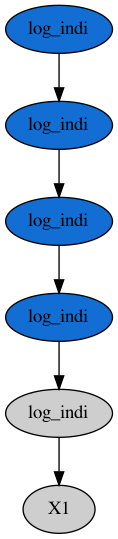

In [74]:
print(est_gp_index._programs[-2][idx].parents)
idx_2 = est_gp_index._programs[-2][idx].parents['parent_idx']
fade_nodes_2 = est_gp_index._programs[-2][idx].parents['parent_nodes'] 
graph = est_gp_index._programs[-3][idx_2].export_graphviz(fade_nodes=fade_nodes_2)
graph = pydotplus.graphviz.graph_from_dot_data(graph) 
Image(graph.create_png())

log_indi(log_indi(log_indi(log_indi(log_indi(X0)))))


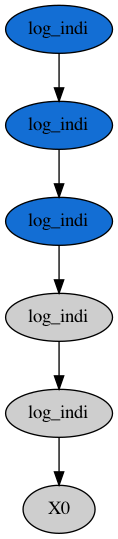

In [26]:
idx = est_gp_index._program.parents['parent_idx']
fade_nodes = est_gp_index._program.parents['parent_nodes'] 
print(est_gp_index._programs[-2][idx])
graph = est_gp_index._programs[-2][idx].export_graphviz(fade_nodes=fade_nodes)
graph = pydotplus.graphviz.graph_from_dot_data(graph) 
Image(graph.create_png())

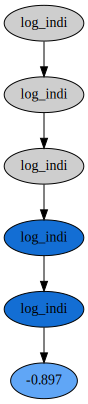

In [62]:
idx = est_gp_index._program.parents['donor_idx']
fade_nodes = est_gp_index._program.parents['donor_nodes']
dot_data = est_gp_index._programs[-2][idx].export_graphviz(fade_nodes=fade_nodes) 
graph = graphviz.Source(dot_data)
graph

In [51]:
# Log Return *10000 as input, 1 generation
init_depth = (1,10)
function_set = ['add', 'sub', 'mul',log_indi]
est_gp_index = SymbolicRegressor(population_size=10000,function_set=function_set,init_depth = init_depth,
                           generations=1, metric='rmse',stopping_criteria=0.01,
                           p_crossover=0.8, p_subtree_mutation=0,
                           p_hoist_mutation=0, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0,n_jobs=-1)
est_gp_index.fit(SP_dataset_x_new, SP_dataset_y_new)
print(est_gp_index._program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    86.00      2.29787e+48        6           142.19          231.495      0.00s
log_indi(mul(X0, add(X1, X0)))


In [92]:
# Log Return *10000 as input
init_depth = (1,10)
function_set = ['add', 'sub', 'mul',log_indi]
est_gp_index = SymbolicRegressor(population_size=10000,function_set=function_set,init_depth = init_depth,
                           generations=100, metric='rmse',stopping_criteria=0.01,
                           p_crossover=0.8, p_subtree_mutation=0.05,
                           p_hoist_mutation=0.04, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient="auto", random_state=0,n_jobs=-1)
est_gp_index.fit(SP_dataset_x_new, SP_dataset_y_new)
print(est_gp_index._program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    86.00      2.88703e+44        6           142.19          231.495     40.70m
   1     2.69      2.33175e+09        2          143.115          226.334     34.11m
   2     1.47      6.82212e+09        2          142.175          231.575     28.10m
   3     1.27      1.26614e+11        1          141.665           234.37     26.65m
   4     1.30      1.96821e+09        1          141.102          237.383     26.58m
   5     1.25      5.14427e+08        1          142.437          230.132     27.20m
   6     1.31      4.27044e+09        1          139.885          243.738     25.11m
   7     1.32      7.34103e+12        1           140.84          238.768     26.20m
   8     1.26      6.81933e+08        1          143.003          226.986  

KeyboardInterrupt: 

In [98]:
print(est_gp_index._program)

mul(sub(sub(mul(sub(X2, sub(X2, log_indi(sub(sub(mul(mul(sub(mul(sub(log_indi(mul(X0, sub(mul(log_indi(log_indi(sub(X2, sub(log_indi(sub(add(log_indi(sub(0.018, 0.751)), 0.629), mul(-0.704, 0.258))), X1)))), log_indi(sub(log_indi(log_indi(add(sub(X1, -0.063), sub(X2, X0)))), X0))), X1))), X2), 0.096), X2), 0.096), 0.096), X2), X1)))), add(X2, mul(0.096, sub(sub(-0.115, -0.618), add(log_indi(0.096), log_indi(mul(X2, 0.096))))))), X1), X2), 0.096)


In [25]:
# Log Return *1000 as input, 10 generation
init_depth = (1,10)
function_set = ['add', 'sub', 'mul',log_indi]
est_gp_index = SymbolicRegressor(population_size=10000,function_set=function_set,init_depth = init_depth,
                           generations=10, metric='rmse',stopping_criteria=0.01,
                           p_crossover=0.8, p_subtree_mutation=0,
                           p_hoist_mutation=0, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0,n_jobs=-1)
est_gp_index.fit(SP_dataset_x_new/10, SP_dataset_y_new/10)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    86.00      3.60702e+26        6           14.219          23.1495      2.91m
   1     8.94           124937        8          14.3115          22.6334      2.19m
   2     6.07          46432.5        1          14.2097          23.3252      1.84m
   3     4.81       3.1665e+07        7           14.166          23.4386      1.49m
   4     4.52          77956.4        3          14.1093          23.7426      1.35m
   5     4.19          679.103        4          14.2417          23.0241      1.43m
   6     3.75          26.8315        3          13.9885          24.3738      1.49m
   7     3.39          18.2023        6          14.2808          22.8066      1.46m
   8     3.26          17.9665        2          14.2993          22.7027  

SymbolicRegressor(function_set=['add', 'sub', 'mul',
                  generations=10, init_depth=(1, 10), max_samples=0.9,
                  metric='rmse', n_jobs=-1, p_crossover=0.8, p_hoist_mutation=0,
                  p_point_mutation=0.1, p_subtree_mutation=0,
                  parsimony_coefficient=0.01, population_size=10000,
                  random_state=0, stopping_criteria=0.01, verbose=1)

In [26]:
print(est_gp_index._program)

sub(log_indi(-0.268), 0.990)


In [27]:
# Log return * 1000,20 generation
init_depth = (1,10)
function_set = ['add', 'sub', 'mul',log_indi]
est_gp_index = SymbolicRegressor(population_size=10000,function_set=function_set,init_depth = init_depth,
                           generations=20, metric='rmse',stopping_criteria=0.01,
                           p_crossover=0.8, p_subtree_mutation=0,
                           p_hoist_mutation=0, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0,n_jobs=-1)
est_gp_index.fit(SP_dataset_x_new/10, SP_dataset_y_new/10)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    86.00      3.60702e+26        6           14.219          23.1495      6.75m
   1     8.94           124937        8          14.3115          22.6334      5.35m
   2     6.07          46432.5        1          14.2097          23.3252      5.05m
   3     4.81       3.1665e+07        7           14.166          23.4386      4.36m
   4     4.52          77956.4        3          14.1093          23.7426      4.78m
   5     4.19          679.103        4          14.2417          23.0241      5.40m
   6     3.75          26.8315        3          13.9885          24.3738      6.75m
   7     3.39          18.2023        6          14.2808          22.8066      9.62m
   8     3.26          17.9665        2          14.2993          22.7027  

SymbolicRegressor(function_set=['add', 'sub', 'mul',
                  init_depth=(1, 10), max_samples=0.9, metric='rmse', n_jobs=-1,
                  p_crossover=0.8, p_hoist_mutation=0, p_point_mutation=0.1,
                  p_subtree_mutation=0, parsimony_coefficient=0.01,
                  population_size=10000, random_state=0, stopping_criteria=0.01,
                  verbose=1)

In [28]:
print(est_gp_index._program)

log_indi(log_indi(log_indi(X0)))


In [35]:
print(SP_In_Sample.values)

[ 0.          0.01573466  0.00453977 ... -0.0125366   0.01031225
 -0.00382471]


In [40]:
normalized = preprocessing.normalize([SP_In_Sample.values])
print(normalized[0])

[ 0.          0.02592138  0.00747885 ... -0.02065287  0.01698847
 -0.00630084]


In [41]:
normalized_SP_In_Sample = normalized[0]

In [42]:
print(normalized_SP_In_Sample)

[ 0.          0.02592138  0.00747885 ... -0.02065287  0.01698847
 -0.00630084]


In [46]:
# Log return normalized,20 generation
init_depth = (1,10)
function_set = ['add', 'sub', 'mul',log_indi]
est_gp_index = SymbolicRegressor(population_size=10000,function_set=function_set,init_depth = init_depth,
                           generations=20, metric='rmse',stopping_criteria=0.01,
                           p_crossover=0.8, p_subtree_mutation=0,
                           p_hoist_mutation=0, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0,n_jobs=-1)
est_gp_index.fit(SP_dataset_x, SP_dataset_y)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    86.00         0.212347        6        0.0234245        0.0381366      6.62m
   1     2.58        0.0378235        2        0.0235279        0.0375623      4.92m
   2     1.93        0.0325009        2        0.0234666        0.0379039      3.94m
   3     1.79        0.0322129        1        0.0233446        0.0386061      4.30m
   4     1.15        0.0282422        1        0.0232557        0.0390834      3.84m
   5     1.00        0.0261859        1        0.0233234        0.0387208      4.27m
   6     1.00        0.0256323        1        0.0230523        0.0401474      2.96m
   7     1.00        0.0261454        1        0.0232083        0.0393348      2.77m
   8     1.00        0.0259737        1        0.0235665        0.0373803  

KeyboardInterrupt: 

In [47]:
# Log return normalized*100,20 generation
init_depth = (1,10)
function_set = ['add', 'sub', 'mul',log_indi]
est_gp_index = SymbolicRegressor(population_size=10000,function_set=function_set,init_depth = init_depth,
                           generations=20, metric='rmse',stopping_criteria=0.01,
                           p_crossover=0.8, p_subtree_mutation=0,
                           p_hoist_mutation=0, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0,n_jobs=-1)
est_gp_index.fit(SP_dataset_x*100, SP_dataset_y*100)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    86.00      2.15757e+13        6          2.34245          3.81366      6.50m
   1     4.14          3.41944        8          2.35769          3.72865      5.94m
   2     2.78          2.87301        2          2.34666          3.79039      4.45m
   3     2.44          2.64057        2          2.33371          3.86129      4.14m
   4     2.35          2.60842        4          2.32437          3.91138      4.16m
   5     2.29          2.59219        2          2.34657          3.79093      5.08m
   6     2.23          2.59095        2          2.30448          4.01535      6.16m
   7     2.19          2.58231        2          2.32019          3.93354      6.64m
   8     2.16          2.58494        2          2.36151          3.70696  

SymbolicRegressor(function_set=['add', 'sub', 'mul',
                  init_depth=(1, 10), max_samples=0.9, metric='rmse', n_jobs=-1,
                  p_crossover=0.8, p_hoist_mutation=0, p_point_mutation=0.1,
                  p_subtree_mutation=0, parsimony_coefficient=0.01,
                  population_size=10000, random_state=0, stopping_criteria=0.01,
                  verbose=1)

In [ ]:
# Log Return *10000 as input
init_depth = (1,10)
function_set = ['add', 'sub', 'mul',log_indi]
est_gp_index = SymbolicRegressor(population_size=10000,function_set=function_set,init_depth = init_depth,
                           generations=100, metric='rmse',stopping_criteria=0.01,
                           p_crossover=0.8, p_subtree_mutation=0.05,
                           p_hoist_mutation=0.049, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.001, random_state=0,n_jobs=-1)
est_gp_index.fit(SP_dataset_x_new, SP_dataset_y_new)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    86.00      2.88703e+44        6           142.19          231.495     38.24m
   1    81.16      1.89297e+21        2          142.818          228.008     46.39m
   2    86.43      9.70936e+23      110          141.931          232.912     52.61m
   3    85.57      1.84083e+26        8           141.66          234.386     76.54m
   4    81.98      2.82975e+29        5          141.093          237.426     53.13m
   5    73.60      3.60785e+21        4           142.44          230.115     59.56m
   6    66.59      1.99747e+17       95          139.885          243.738     79.77m
   7    60.89      3.74083e+18       15          142.808          228.066    131.04m
   8    64.28      2.99833e+21       49          142.993          227.027  

/Users/seungjuseo/.pyenv/versions/3.7.1/envs/myenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


  25    53.49      3.70141e+12        5          141.639          234.496    254.83m
  26    55.17      2.55871e+15       19          141.128          237.241    333.33m
  27    55.33      5.73476e+12       47          140.922          238.333    323.50m
  28    54.88        1.976e+17       17          142.095          232.014    256.14m
  29    55.23      1.44913e+10       40          140.888           238.51    252.36m
  30    54.93      5.88718e+13       68          141.536          235.052    282.38m
  31    54.07      2.24444e+09       74          138.822          249.117    353.27m
  32    53.49      1.03023e+18       60          140.712          239.438    307.26m
  33    55.68      3.16578e+16        7          142.373          230.486    267.14m
  34    54.60      2.90928e+20       35          140.039          242.946    277.57m
  35    56.02      1.77809e+21      118          142.311          230.828    266.63m
  36    58.75      8.56657e+12       35          142.302         

In [24]:
# log return as input
function_set_return = ['add', 'sub', 'mul']
# ['add', 'sub', 'mul', 'div', 'inv', 'abs', 'neg', 'max', 'min', 'sqrt', 'log'] 
est_gp_return = SymbolicRegressor(population_size=10000,function_set=function_set,
                           generations=10, 
                           p_crossover=0.8, p_subtree_mutation=0,
                           p_hoist_mutation=0, p_point_mutation=0.2,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp_return.fit(SP_dataset_x, SP_dataset_y)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    32.50         0.287083        7       0.00923436        0.0132803      2.08m
   1     4.37        0.0284516        3       0.00923251        0.0132011     55.01s
   2     1.46        0.0139747        3       0.00925548        0.0126834     45.46s
   3     1.00        0.0152442        1         0.013291        0.0188797     36.10s
   4     1.00        0.0149887        1        0.0132732        0.0190397     30.47s
   5     1.00        0.0151659        1        0.0132675        0.0190906     24.98s
   6     1.00        0.0147879        1        0.0133225        0.0185981     18.10s
   7     1.00        0.0150914        1         0.013278        0.0189962     12.03s
   8     1.00        0.0148499        1        0.0132559        0.0191941  

SymbolicRegressor(function_set=['add', 'sub', 'mul'], generations=10,
                  max_samples=0.9, p_crossover=0.8, p_hoist_mutation=0,
                  p_point_mutation=0.2, p_subtree_mutation=0,
                  parsimony_coefficient=0.01, population_size=10000,
                  random_state=0, verbose=1)

In [88]:
print(est_gp_index._program)

X2


In [23]:
print(est_gp_return._program)

NameError: name 'est_gp_return' is not defined

In [161]:
 print(gp._best_programs[0])

mul(X1, log(mul(X2, X1)))


In [140]:
SP1_Index

Dates
2006-01-02    100.000000
2006-01-03    101.573466
2006-01-04    102.034586
2006-01-05    102.098313
2006-01-06    102.931579
                 ...    
2017-12-25    170.125406
2017-12-26    170.188730
2017-12-27    170.081025
2017-12-28    170.100025
2017-12-29    169.484559
Name: SP1 Index, Length: 3130, dtype: float64

/Users/seungjuseo/.pyenv/versions/3.7.1/envs/myenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


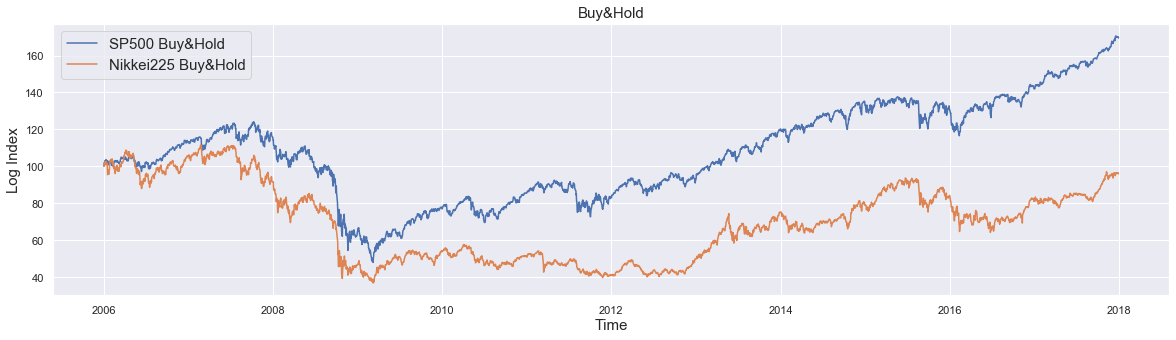

In [11]:
plt.figure(figsize=(20,5))
g_1 = plt.subplot()
g_1.plot(SP1_Index, label="SP500 Buy&Hold")
g_1.plot(NK1_Index, label="Nikkei225 Buy&Hold")
g_1.set_xlabel("Time",fontsize=15)
g_1.set_ylabel("Log Index",fontsize=15)
g_1.set_title("Buy&Hold",fontsize=15)
g_1.legend(fontsize=15)

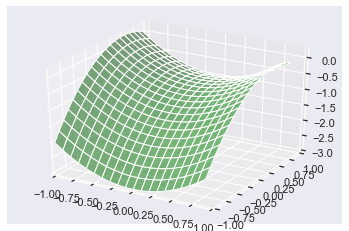

In [15]:
x0 = np.arange(-1, 1, 1/10.)
x1 = np.arange(-1, 1, 1/10.)
x0, x1 = np.meshgrid(x0, x1)
y_truth = x0**2 - x1**2 + x1 - 1

ax = plt.figure().gca(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
surf = ax.plot_surface(x0, x1, y_truth, rstride=1, cstride=1,
                       color='green', alpha=0.5)
plt.show()

In [32]:
rng = check_random_state(0)

# Training samples
X_train = rng.uniform(-1, 1, 100).reshape(25, 4)
y_train = X_train[:, 0]**2 - X_train[:, 1]**2 + X_train[:, 1] - 1 + X_train[:, 2] - X_train[:, 3]

# Testing samples
X_test = rng.uniform(-1, 1, 100).reshape(25, 4)
y_test = X_test[:, 0]**2 - X_test[:, 1]**2 + X_test[:, 1] - 1 + X_test[:, 2] - X_test[:,3]


In [68]:
X_train

array([[ 0.09762701,  0.43037873,  0.20552675,  0.08976637],
       [-0.1526904 ,  0.29178823, -0.12482558,  0.783546  ],
       [ 0.92732552, -0.23311696,  0.58345008,  0.05778984],
       [ 0.13608912,  0.85119328, -0.85792788, -0.8257414 ],
       [-0.95956321,  0.66523969,  0.5563135 ,  0.7400243 ],
       [ 0.95723668,  0.59831713, -0.07704128,  0.56105835],
       [-0.76345115,  0.27984204, -0.71329343,  0.88933783],
       [ 0.04369664, -0.17067612, -0.47088878,  0.54846738],
       [-0.08769934,  0.1368679 , -0.9624204 ,  0.23527099],
       [ 0.22419145,  0.23386799,  0.88749616,  0.3636406 ],
       [-0.2809842 , -0.12593609,  0.39526239, -0.87954906],
       [ 0.33353343,  0.34127574, -0.57923488, -0.7421474 ],
       [-0.3691433 , -0.27257846,  0.14039354, -0.12279697],
       [ 0.97674768, -0.79591038, -0.58224649, -0.67738096],
       [ 0.30621665, -0.49341679, -0.06737845, -0.51114882],
       [-0.68206083, -0.77924972,  0.31265918, -0.7236341 ],
       [-0.60683528, -0.

In [35]:
y_train

array([-6.29555702e-01, -1.67840936e+00,  9.81323781e-02, -8.87002951e-01,
       -4.02534055e-02, -4.81463816e-01, -1.81824313e+00, -2.21725322e+00,
       -2.07186514e+00, -2.46708882e-01,  2.11967577e-01, -5.01036315e-01,
       -9.47420185e-01, -1.38021321e+00, -1.19933793e+00, -8.84979584e-01,
        4.84550979e-01, -9.87905600e-01,  1.47507682e+00, -1.79309327e+00,
       -2.32500610e+00, -8.13031282e-01, -1.55319988e+00,  1.85289670e-04,
       -1.20254492e+00])

In [36]:
X_test

array([[ 0.35563307, -0.45998405,  0.47038804,  0.92437709],
       [-0.50249371,  0.15231467,  0.18408386,  0.14450381],
       [-0.55383673,  0.90549802, -0.10574924,  0.69281734],
       [ 0.39895855, -0.4051261 ,  0.62759564, -0.20698852],
       [ 0.76220639,  0.16254575,  0.76347072,  0.38506318],
       [ 0.45050856,  0.00264876,  0.91216727,  0.2879804 ],
       [-0.1522899 ,  0.21278643, -0.9616136 , -0.39685037],
       [ 0.32034707, -0.41984479,  0.23603086, -0.1424626 ],
       [-0.72905187, -0.40343535,  0.13992982,  0.18174552],
       [ 0.1486505 ,  0.30640164,  0.30420654, -0.13716313],
       [ 0.79309319, -0.26487626, -0.12827015,  0.78384671],
       [ 0.61238798,  0.40777717, -0.79954623,  0.83896523],
       [ 0.4284826 ,  0.99769401, -0.70110339,  0.73625211],
       [-0.67501413,  0.23111913, -0.75236003,  0.69601646],
       [ 0.61463792,  0.13820148, -0.18563341, -0.86166601],
       [ 0.39485755, -0.09291463,  0.4441112 ,  0.73276465],
       [ 0.95104301,  0.

In [37]:
y_test

array([-1.99908355, -0.57880511, -1.40626011, -0.57550117,  0.09549076,
       -0.17021342, -1.37406266, -1.11499872, -1.0764945 , -0.32401369,
       -1.61815574, -2.02199747, -2.2514575 , -1.81502934,  0.1729142 ,
       -1.23428874, -0.58682254, -0.94306905, -1.39068709,  0.56396357,
        0.31232036, -0.17840821, -0.92898953, -0.00903921, -2.18821378])

In [43]:
function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                'abs', 'neg', 'inv', 'max', 'min', 'sin', 'cos', 'tan']
est_gp = SymbolicRegressor(population_size=5000,function_set=function_set,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.20          3.95213        7          0.55169         0.425842      1.39m
   1     6.45          1.16128        7         0.482134         0.935921      1.03m
   2     4.96           1.0816       13          0.44763         0.551874     55.07s
   3     5.27           1.0925       13          0.40666         0.852321     50.91s
   4     6.08          1.01437       13         0.395927         0.931023     56.12s
   5     6.04          1.00497        9         0.384327         0.918529     44.82s
   6     5.50          1.04711       10         0.324342          1.09975     40.95s
   7     5.33          1.01176        7         0.346343          1.00403     37.43s
   8     5.69         0.977543        9          0.32655         0.966961  

SymbolicRegressor(function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                'abs', 'neg', 'inv', 'max', 'min', 'sin', 'cos',
                                'tan'],
                  max_samples=0.9, p_crossover=0.7, p_hoist_mutation=0.05,
                  p_point_mutation=0.1, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=5000,
                  random_state=0, stopping_criteria=0.01, verbose=1)

In [44]:
print(est_gp._program)

add(sub(X2, add(cos(X0), X3)), tan(X1))


In [24]:
est_tree = DecisionTreeRegressor()
est_tree.fit(X_train, y_train)
est_rf = RandomForestRegressor(n_estimators=10)
est_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10)

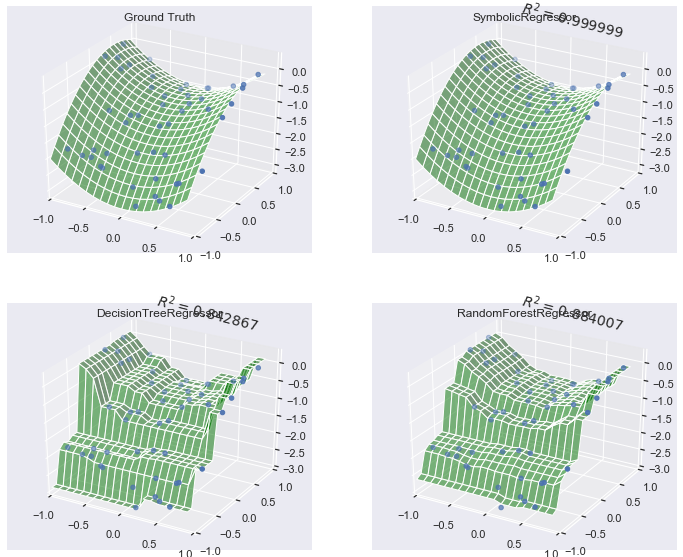

In [25]:
y_gp = est_gp.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_gp = est_gp.score(X_test, y_test)
y_tree = est_tree.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_tree = est_tree.score(X_test, y_test)
y_rf = est_rf.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_rf = est_rf.score(X_test, y_test)

fig = plt.figure(figsize=(12, 10))

for i, (y, score, title) in enumerate([(y_truth, None, "Ground Truth"),
                                       (y_gp, score_gp, "SymbolicRegressor"),
                                       (y_tree, score_tree, "DecisionTreeRegressor"),
                                       (y_rf, score_rf, "RandomForestRegressor")]):

    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xticks(np.arange(-1, 1.01, .5))
    ax.set_yticks(np.arange(-1, 1.01, .5))
    surf = ax.plot_surface(x0, x1, y, rstride=1, cstride=1, color='green', alpha=0.5)
    points = ax.scatter(X_train[:, 0], X_train[:, 1], y_train)
    if score is not None:
        score = ax.text(-.7, 1, .2, "$R^2 =\/ %.6f$" % score, 'x', fontsize=14)
    plt.title(title)

plt.show()

In [27]:
print(est_gp._program.parents)

{'method': 'Crossover', 'parent_idx': 1555, 'parent_nodes': range(1, 4), 'donor_idx': 78, 'donor_nodes': []}
